# MIT-GSL Uruguay 

## January 2020

-----

# Week - 2 | Lesson - 02 
# NLP: Product embeddings

1. After introducing the concept of embeddings through NLP, we extend the notion of embeddings to other settings
2. Note that embeddings are dense continuous representations for discrete, sparse tokens - this makes embeddings widely applicable
3. We will use the concept of embeddings to understand the world of e-commerce better 

---

# Word2Vec and its Applications to Market-Basket Data

# Instacart Grocery Dataset

### Source: https://www.instacart.com/datasets/grocery-shopping-2017

1. Instacart is an online grocery delivery service
2. They have made available 3M grocery orders for over 200K users
3. They provide between 4 to 100 orders for each user and each order contains the sequence of products purchased
4. We also have a brief description of the products

### Overview:
1. We will use this data to build an understanding of word embeddings and investigate their application to downstream tasks
2. For this purpose, we will consider each purchase basket to be a sentence with an unordered sequence of words

---

# 0. Import Modules

In [122]:
# ==============================================
# 0. Module imports
# ==============================================

import pandas as pd
pd.options.display.max_colwidth = 100
import numpy as np
from itertools import product
import csv

# w2v
import gensim

# text processing
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import ToktokTokenizer
import string
import re # regular expressions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

# T-Sne
#import umap
#from openTSNE import TSNE, TSNEEmbedding, affinity, initialization
#from openTSNE import initialization
#from openTSNE.callbacks import ErrorLogger
from sklearn.manifold import TSNE


# utils
from sklearn import utils


# parallel processing
import multiprocessing
from joblib import delayed, Parallel

# time code
import time

# 2-d visualiztion
%matplotlib inline
from ggplot import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os
os.chdir("/pool001/madhavk/gsl-uruguay/W-02-NLP/")

In [123]:
# =========================================================
# set directories
# =========================================================

# raw data
raw_data_dir = "nlp-data/in-grocery/instacart_2017_05_01/"

# processed data
process_dir = "nlp-data/in-grocery/prepared-data/"

In [124]:
# =========================================================
# processed files
# =========================================================

os.listdir(process_dir)

['orders-split-v1.csv',
 'all-orders-wide-v1.csv',
 'all-orders-long-v1.csv',
 'products-merged-v1.csv']

In [125]:
# =========================================================
# global parameters
# =========================================================

# show entire value of cell in pandas
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

# number of cpus
cpus = multiprocessing.cpu_count()
f"Number of CPUs: {cpus}"

'Number of CPUs: 28'

------

# 1. Import grocery data

## 1.1. Order level data

In [7]:
# =========================================================
# order-level data
# =========================================================

orders_wide = pd.read_csv(process_dir + "all-orders-wide-v1.csv")
print(orders_wide.shape)

(3152555, 4)


In [9]:
display(orders_wide.head(10))

,order_id,product_id,num_products,eval
0,2,33120 28985 9327 45918 30035 17794 40141 1819,8,prior
1,3,33754 24838 17704 21903 17668 46667 17461 32665,8,prior
2,4,46842 39758 27761 10054 21351 22598 34862 40285 17616 25146 32645 41276,12,prior
3,5,13176 47329 27966 23909 48370 13245 27360 6348 40878 6184 48002 20914 37011 12962 45698 41176 48366 47209 46522 38693 48825 8479,22,prior
4,7,34050 46802,2,prior
5,9,21405 47890 11182 2014 29193 34203 14992 31506 23288 44533 18362 432 3990 14183,14,prior
6,10,24852 4796 31717 47766 4605 1529 21137 22122 34134 27156 14992 49235 26842 3464 25720,15,prior
7,11,30162 5994 1313 31506,4,prior
8,12,30597 15221 43772 37886 37215 34335 26910 38888 38050 29471,10,prior
9,13,17330 27407 35419 196 44635 26878 25783 41290 33198 23020 36086 3800 25952,13,prior


In [10]:
# =========================================================
# orders meta-data
# =========================================================

orders_meta = pd.read_csv(process_dir + "orders-split-v1.csv")
print(orders_meta.shape)

(3346083, 7)


In [11]:
display(orders_meta.head(10))

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval
0,2539329,1,1,2,8,NaN,prior
1,2398795,1,2,3,7,15.0,prior
2,473747,1,3,3,12,21.0,prior
3,2254736,1,4,4,7,29.0,prior
4,431534,1,5,4,15,28.0,prior
5,3367565,1,6,2,7,19.0,prior
6,550135,1,7,1,9,20.0,prior
7,3108588,1,8,1,14,14.0,prior
8,2295261,1,9,1,16,0.0,prior
9,2550362,1,10,4,8,30.0,prior


----

## 1.2. Merge train-val-test split

In [12]:
# =========================================================
# merge orders-wide and orders-meta
# =========================================================

orders_wide.drop(labels = "eval", axis = 1, inplace = True)

In [13]:
# merge
orders_wide = pd.merge(orders_wide, orders_meta[["order_id", "user_id", "eval"]],
                       on = "order_id", how = "left")
print(orders_wide.shape)

(3152555, 5)


In [14]:
display(orders_wide.head(10))

,order_id,product_id,num_products,user_id,eval
0,2,33120 28985 9327 45918 30035 17794 40141 1819,8,202279,prior
1,3,33754 24838 17704 21903 17668 46667 17461 32665,8,205970,prior
2,4,46842 39758 27761 10054 21351 22598 34862 40285 17616 25146 32645 41276,12,178520,prior
3,5,13176 47329 27966 23909 48370 13245 27360 6348 40878 6184 48002 20914 37011 12962 45698 41176 48366 47209 46522 38693 48825 8479,22,156122,prior
4,7,34050 46802,2,142903,prior
5,9,21405 47890 11182 2014 29193 34203 14992 31506 23288 44533 18362 432 3990 14183,14,139016,prior
6,10,24852 4796 31717 47766 4605 1529 21137 22122 34134 27156 14992 49235 26842 3464 25720,15,135442,prior
7,11,30162 5994 1313 31506,4,143742,prior
8,12,30597 15221 43772 37886 37215 34335 26910 38888 38050 29471,10,152610,prior
9,13,17330 27407 35419 196 44635 26878 25783 41290 33198 23020 36086 3800 25952,13,45082,prior


In [15]:
# =========================================================
# eval-set distribution
# =========================================================

orders_wide["eval"].value_counts()

prior    2959079
train    116333 
val      38701  
test     38442  
Name: eval, dtype: int64

In [16]:
# clear some space
del orders_meta

----

## 1.3. Import product info data

In [17]:
products = pd.read_csv(process_dir + "products-merged-v1.csv")
print(products.shape)

(49688, 6)


In [18]:
display(products.head(10))

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry
5,6,Dry Nose Oil,11,11,cold flu allergy,personal care
6,7,Pure Coconut Water With Orange,98,7,juice nectars,beverages
7,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen produce,frozen
8,9,Light Strawberry Blueberry Yogurt,120,16,yogurt,dairy eggs
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,water seltzer sparkling water,beverages


In [19]:
#===============================================
# top departments
#===============================================
products["department"].value_counts()

personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets               972 
meat seafood       907 
other              548 
bulk               38  
Name: department, dtype: int64

In [20]:
#===============================================
# top aisles
#===============================================
products["aisle"].value_counts()

missing                          1258
candy chocolate                  1246
ice cream ice                    1091
vitamins supplements             1038
yogurt                           1026
chips pretzels                   989 
tea                              894 
packaged cheese                  891 
frozen meals                     880 
cookies cakes                    874 
energy granola bars              832 
hair care                        816 
spices seasonings                797 
juice nectars                    792 
crackers                         747 
soup broth bouillon              737 
baby food formula                718 
coffee                           680 
refrigerated                     675 
cleaning products                655 
baking ingredients               623 
packaged vegetables fruits       615 
asian foods                      605 
nuts seeds dried fruit           582 
fresh vegetables                 569 
oral hygiene                     565 
salad dressi

---

# 2. Data exploration

In [21]:
# long-form of orders
orders_long = pd.read_csv(process_dir + "all-orders-long-v1.csv")
print(orders_long.shape)

(32019330, 5)


In [22]:
display(orders_long.head(20))

,order_id,product_id,add_to_cart_order,reordered,eval
0,2,33120,1,1,prior
1,2,28985,2,1,prior
2,2,9327,3,0,prior
3,2,45918,4,1,prior
4,2,30035,5,0,prior
5,2,17794,6,1,prior
6,2,40141,7,1,prior
7,2,1819,8,1,prior
8,3,33754,1,1,prior
9,3,24838,2,1,prior


## 2.1. Most frequently purchased products

In [23]:
# most frequently bought products
most_freq_purchased = pd.DataFrame(orders_long["product_id"].value_counts())
most_freq_purchased.reset_index(drop = False, inplace = True)
most_freq_purchased.columns = ["product_id", "freq"]
display(most_freq_purchased.head(10))

,product_id,freq
0,24852,491291
1,13176,394930
2,21137,275577
3,21903,251705
4,47209,220877
5,47766,184224
6,47626,160792
7,16797,149445
8,26209,146660
9,27845,142813


In [24]:
# merge with product info
most_freq_purchased = pd.merge(most_freq_purchased, products, on = "product_id", how = "left")
display(most_freq_purchased.head(20))

,product_id,freq,product_name,aisle_id,department_id,aisle,department
0,24852,491291,Banana,24,4,fresh fruits,produce
1,13176,394930,Bag of Organic Bananas,24,4,fresh fruits,produce
2,21137,275577,Organic Strawberries,24,4,fresh fruits,produce
3,21903,251705,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
4,47209,220877,Organic Hass Avocado,24,4,fresh fruits,produce
5,47766,184224,Organic Avocado,24,4,fresh fruits,produce
6,47626,160792,Large Lemon,24,4,fresh fruits,produce
7,16797,149445,Strawberries,24,4,fresh fruits,produce
8,26209,146660,Limes,24,4,fresh fruits,produce
9,27845,142813,Organic Whole Milk,84,16,milk,dairy eggs


In [25]:
display(most_freq_purchased.tail(20))

,product_id,freq,product_name,aisle_id,department_id,aisle,department
14320,15612,206,Unwrapped Bites,45,19,candy chocolate,snacks
14321,20434,206,Sardines in Olive Oil,95,15,canned meat seafood,canned goods
14322,22315,206,Slow Churned Chocolate Light Ice Cream,37,1,ice cream ice,frozen
14323,39328,206,Organic Mexican Chocolate Ice Cream,37,1,ice cream ice,frozen
14324,12549,206,"Salad Dressing, Bleu Cheese, Vegan",89,13,salad dressing toppings,pantry
14325,35355,205,94% Fat Free Microwave Butter Popcorn,23,19,popcorn jerky,snacks
14326,5634,205,Organic Pasture Raised Local Eggs,86,16,eggs,dairy eggs
14327,18975,205,Uncured Cherry Smoked Bacon,106,12,hot dogs bacon sausage,meat seafood
14328,20814,205,Sensitive with Iron Infant Formula,92,18,baby food formula,babies
14329,46815,205,Ultimate Omega 1280mg omega-3,47,11,vitamins supplements,personal care


In [26]:
# most popular aisle
aisle = most_freq_purchased.groupby("aisle").agg({"freq": "sum"})
aisle = aisle.reset_index(drop = False, inplace = False).sort_values("freq", ascending = False)
display(aisle)

,aisle,freq
50,fresh fruits,3782826
53,fresh vegetables,3553596
98,packaged vegetables fruits,1823815
133,yogurt,1475395
93,packaged cheese,990483
83,milk,918611
131,water seltzer sparkling water,868265
25,chips pretzels,717827
119,soy lactosefree,655592
11,bread,588261


In [27]:
# most purchased department
dept = most_freq_purchased.groupby("department").agg({"freq": "sum"})
dept = dept.reset_index(drop = False, inplace = False).sort_values("freq", ascending = False)
dept

,department,freq
19,produce,9840710
7,dairy eggs,5522579
20,snacks,2767610
3,beverages,2641843
10,frozen,2178717
16,pantry,1763171
2,bakery,1168021
8,deli,1046768
6,canned goods,1032645
9,dry goods pasta,833181


-----

## 2.2. Co-purchased products

In [28]:
# ===========================================
# Generate co-purchase matrix
# ===========================================

def CoPurchaseMatrix(orders_wide, product_info = True):
    '''
    orders_wide is order-level data with one row per order
    '''
    count_vec = CountVectorizer(ngram_range = (1,1), binary = True, 
                            token_pattern = "\\b\\w+\\b") # sku counts
    pur_mat = count_vec.fit_transform(orders_wide["product_id"])
    co_pur_mat = (pur_mat.T * pur_mat) #copurchase matrix
    co_pur_mat.setdiag(0) # set diagonal to 0
    co_pur_mat_df = pd.DataFrame(co_pur_mat.todense()) # convert to data frame
    co_pur_mat_df.index = count_vec.vocabulary_ # row names from sku-ids
    co_pur_mat_df.columns = count_vec.vocabulary_ # column names from sku-ids
    co_pur_mat_df = co_pur_mat_df.where(np.triu(np.ones(co_pur_mat_df.shape)).astype(np.bool)) # consider the uppre tri
    co_pur_mat_df = co_pur_mat_df.stack().reset_index() # melt to sku-1 and sku-2 per row
    co_pur_mat_df.columns = ["product_id_1", "product_id_2", "copur"]
    co_pur_mat_df = co_pur_mat_df.loc[co_pur_mat_df["copur"] > 0, :] # subset for copur > 0
    co_pur_mat_df_top = co_pur_mat_df.sort_values(["product_id_1", "copur"], ascending = False)
    co_pur_mat_df_top = co_pur_mat_df_top.drop_duplicates(["product_id_1"], keep = "first")
    co_pur_mat_df_top["product_id_1"] = co_pur_mat_df_top["product_id_1"].astype(int) # fix data types
    co_pur_mat_df_top["product_id_2"] = co_pur_mat_df_top["product_id_2"].astype(int) # fix data types
    co_pur_mat_df_top = co_pur_mat_df_top.sort_values(["copur"], ascending = False).reset_index(drop = True)
    if product_info:
        co_pur_mat_df_top = pd.merge(co_pur_mat_df_top, products, how = "left", 
                                     left_on = "product_id_1", right_on = "product_id")
        co_pur_mat_df_top.drop("product_id", axis = 1, inplace = True)
        co_pur_mat_df_top = pd.merge(co_pur_mat_df_top, products, how = "left",
                                     left_on = "product_id_2", right_on = "product_id", 
                                     suffixes = ["_1", "_2"])
        co_pur_mat_df_top.drop("product_id", axis = 1, inplace = True)
        col_order = ['product_id_1', 'product_id_2', 'copur', 'product_name_1', 'product_name_2',
                             'aisle_1', 'aisle_2', 'department_1', 'department_2', 
                             'aisle_id_1', 'aisle_id_2', 'department_id_1', 'department_id_2']
        co_pur_mat_df_top = co_pur_mat_df_top[col_order]
    return(co_pur_mat_df_top)

In [29]:
# calculate copurchases
copur = CoPurchaseMatrix(orders_wide = orders_wide, product_info = True)
print(copur.shape)

(14332, 13)


In [30]:
display(copur[["product_name_1", "product_name_2", "copur", "aisle_1", "aisle_2"]].head(20))

,product_name_1,product_name_2,copur,aisle_1,aisle_2
0,Organic Lacinato (Dinosaur) Kale,Soft Eating Strawberry Flavored Licorice,64761.0,fresh vegetables,candy chocolate
1,"Mighty 4 Sweet Potato, Blueberry, Millet & Greek Yogurt Tots Snack",Nut Delight Fruit & Nut Bar,58330.0,baby food formula,energy granola bars
2,Nut Delight Fruit & Nut Bar,Carrot Bunch,55611.0,energy granola bars,fresh vegetables
3,Natural Finely Shredded Triple Cheddar Cheese,Nut Delight Fruit & Nut Bar,53395.0,packaged cheese,energy granola bars
4,Italian Style Meatballs & Mozzarella Sandwiches,Nut Delight Fruit & Nut Bar,43180.0,frozen meals,energy granola bars
5,Organic Granny Smith Apples,Garlic Spice Blend Paste,28998.0,fresh fruits,packaged vegetables fruits
6,Pecan Pie Fruit & Nut Food Bar,Soft Eating Strawberry Flavored Licorice,26812.0,energy granola bars,candy chocolate
7,Garlic Spice Blend Paste,Carrot Bunch,25766.0,packaged vegetables fruits,fresh vegetables
8,"Almond Coconut Bar, Organic",2nd Foods Organic Pear and Spinach Baby Food,22923.0,energy granola bars,baby food formula
9,Soft Eating Strawberry Flavored Licorice,Spicy Minis Guacamole,22027.0,candy chocolate,fresh dips tapenades


----

# 3. Split train-val-test datasets


In [31]:
#===============================================
# split train-val-test
#===============================================

train = orders_wide.loc[orders_wide["eval"].isin(["prior", "train"]), :]
val = orders_wide.loc[orders_wide["eval"] == "val", :]
test = orders_wide.loc[orders_wide["eval"] == "test", :]
print("train size:", train.shape)
print("val size:", val.shape)
print("test size:", test.shape)

train size: (3075412, 5)
val size: (38701, 5)
test size: (38442, 5)


In [32]:
# clear more space
del orders_wide, orders_long

In [33]:
display(train.head())

,order_id,product_id,num_products,user_id,eval
0,2,33120 28985 9327 45918 30035 17794 40141 1819,8,202279,prior
1,3,33754 24838 17704 21903 17668 46667 17461 32665,8,205970,prior
2,4,46842 39758 27761 10054 21351 22598 34862 40285 17616 25146 32645 41276,12,178520,prior
3,5,13176 47329 27966 23909 48370 13245 27360 6348 40878 6184 48002 20914 37011 12962 45698 41176 48366 47209 46522 38693 48825 8479,22,156122,prior
4,7,34050 46802,2,142903,prior


## 3.1. Random sample for faster processing

In [34]:
#===============================================
# randomly sample training data
#===============================================

sample_size = 1000000
train = train.sample(n = sample_size)
train = train.reset_index(drop = True)
print(train.shape)

(1000000, 5)


In [35]:
display(train.head(10))

,order_id,product_id,num_products,user_id,eval
0,2471322,44257 47209 2966 21903 36522 15290 43768 21938 8518 16797 19678 10246 10749 9210 27451 28756 33120,17,86641,prior
1,1769597,3782 47944 28196 11488 12916 16965 8474,7,165124,prior
2,1811893,14127 4210 6774 4920 26882 42105 14467 34034 45646 36772 35004 1090,12,68350,prior
3,2109136,8615 14996 37552 33438 27086 42701 21616 5479 48487 18418 40969 47209 15630 16290 31506 6489,16,192706,prior
4,1780237,41220 10621 49683 30489 34969 43961 30305 41259 15290,9,204638,prior
5,2405275,23357 9290 5077 38647 12276 32691,6,66619,prior
6,157486,17789 43635 18523 45210 21938 29662 1117 21405 2295 19894 24184 47601 47672 24830 5785 41065 24852 37042 36484 21137,20,14021,prior
7,2081009,8412 21137 15290 4605 2295 45066 34358 28842,8,138676,prior
8,1616330,29574 8959 37158 37141,4,203597,prior
9,1415634,44142 16797 47626 17568 14678 20995 17948 49215 45007 22935 24964 27521 19678 30305 19508 10831,16,173788,prior


## 3.2. Tokenize sentences

In [36]:
# start pool process for parallel procressing
pool = multiprocessing.Pool(processes = cpus)

In [37]:
# training sentences
t0 = time.time()
train_orders = pool.map(word_tokenize, train["product_id"])
t1 = time.time()
print(len(train_orders))

1000000


In [38]:
# time taken
print(f"Time Taken: {t1 - t0}")

Time Taken: 12.013629913330078


In [39]:
# training orders
train_orders[0:3]

[['44257',
  '47209',
  '2966',
  '21903',
  '36522',
  '15290',
  '43768',
  '21938',
  '8518',
  '16797',
  '19678',
  '10246',
  '10749',
  '9210',
  '27451',
  '28756',
  '33120'],
 ['3782', '47944', '28196', '11488', '12916', '16965', '8474'],
 ['14127',
  '4210',
  '6774',
  '4920',
  '26882',
  '42105',
  '14467',
  '34034',
  '45646',
  '36772',
  '35004',
  '1090']]

In [40]:
# validation sentences
t0 = time.time()
val_orders = pool.map(word_tokenize, val["product_id"])
t1 = time.time()
print(len(val_orders))

38701


In [41]:
# test sentences
t0 = time.time()
test_orders = pool.map(word_tokenize, test["product_id"])
t1 = time.time()
print(len(test_orders))

38442


----

# 4. Word2Vec sample model

## 4.1. Define and train model

In [42]:
#===============================================
# define and train model
#===============================================

w2v_1 = gensim.models.Word2Vec(sentences = train_orders,
                               workers = cpus,
                               seed = 1234)

## Model properties

In [43]:
#===============================================
# vocabulary
#===============================================

# vocabulary length
f"Vocab length: {len(w2v_1.wv.vocab)}"

'Vocab length: 14340'

In [44]:
# sample vocabulary
list(w2v_1.wv.vocab.keys())[0:5]

['44257', '47209', '2966', '21903', '36522']

In [45]:
# length of corpus
print(w2v_1.corpus_count)

1000000


In [46]:
# number of iterations
w2v_1.iter

5

In [47]:
#===============================================
# product vectors
#===============================================

# enter product-id
prod_id = "1"
print(w2v_1[prod_id].shape)
print("------------")
print("------------")
print(w2v_1[prod_id])

(100,)
------------
------------
[ 0.51040107 -0.9871397   0.1610078  -0.72007     0.81554234  0.91265905
 -0.79855996 -1.9074913  -0.1168586   1.3211199  -0.14040667 -1.4466741
 -0.5739409  -1.2204967  -0.8314955  -0.07175115 -0.20419927  0.13695759
 -0.18626666 -0.4894335  -0.9253775   1.3370742   0.5814434   0.27304226
  0.17397334 -1.1167864   0.96461016  0.04784713  0.43158486  1.1363447
  0.18188725 -0.14524706  1.8770407  -0.50452673  0.40120453  1.3131435
  0.42463717  1.4732927  -0.37934062  0.0230298   0.00983433  1.1589558
 -0.1079555  -0.8519789   0.01412045 -0.25423118  0.0474599   0.6072742
  1.2279869  -0.955689   -0.0037184   0.9475339   1.1632154  -0.8356101
  1.1021068   0.2535997  -0.33818957  0.47626418  0.1530547   0.7475325
 -0.4246933   0.667999    0.26008344  0.53033656  0.6592674   0.964858
 -1.2839274   0.94901735 -0.74526346  0.6611901   0.04397804  0.90496415
 -0.03109936  0.37944463  0.19202796  1.6826532   0.36819056  0.78134596
 -0.66518176 -0.24753371  0

## 4.2. Update embeddings

In [48]:
#===============================================
# update model weights
#===============================================
w2v_1.train(sentences = train_orders, total_examples = w2v_1.corpus_count, epochs = 2, compute_loss = True)

19307947

## 4.3. Inspect model output

In [49]:
#===============================================
# upadted product vectors
#===============================================

# enter product-id
prod_id = "1"
print(w2v_1[prod_id].shape)
print("------------")
print("------------")
print(w2v_1[prod_id])

(100,)
------------
------------
[ 0.44853285 -1.3102517   0.12992759 -0.7735774   0.59566444  1.0215374
 -1.0330158  -2.030895   -0.26466864  1.2887825  -0.38717744 -1.8992171
 -0.774195   -1.1453438  -0.7627294  -0.23299134  0.01167723  0.18889377
 -0.3049162  -0.39903903 -0.91876805  1.4215368   0.47018337  0.23282193
 -0.00468355 -1.1711432   1.1054262  -0.15103221  0.26130018  1.055509
  0.20406072 -0.16188072  2.1828392  -0.4220309   0.40097904  1.361489
  0.5182848   1.8058708  -0.34834382  0.03726376 -0.17958674  0.9809551
  0.38954514 -0.976529   -0.03675473 -0.15140054 -0.11843224  0.5438809
  1.5437642  -0.95421666  0.21862121  0.93962157  1.4131478  -0.9274882
  1.0727654   0.2541378  -0.53738666  0.5336612  -0.24430013  0.71738386
 -0.5693664   0.5307451  -0.07974265  0.8502986   0.63281435  1.0865378
 -1.725681    1.1676115  -0.76882565  0.64897287 -0.11166891  0.98921144
  0.09638549  0.5002488   0.30839646  1.8929162   0.4798467   0.7162659
 -0.75990725 -0.3667245   1.0

--------

# 5. Improve W2V model

In [50]:
#===============================================
# model parameters
#===============================================

# size of embedding matrix
emb_size = 100

# context window size
cxt_window = 10

# batch size for gradient update
batch_size = 10000

# down-sample high frequency words
hfs = 0.001

# learning rate
lr = 0.05

In [51]:
#===============================================
# define model
#===============================================

w2v_1 = gensim.models.Word2Vec(sentences = train_orders,
                               size = emb_size, # number of columns in embedding matrix
                               hs = 1, # hierarchical softmax
                               negative = 0, # negative sampling
                               window = cxt_window, # context window
                               min_count = 1, # minimum frequency count
                               batch_words = batch_size, # batch size for update
                               alpha = lr, # learning rate
                               sample = hfs, # down sample high frequency words 
                               workers = cpus,
                               seed = 1234)

## 5.1. Score on validation and test

In [52]:
#===============================================
# Score model to get log-likelihood
#===============================================

def ScoreW2V(test_sent, model, normalize = True, avg_over_sent = True):
    test_score = model.score(test_sent, total_sentences = len(test_sent), 
                             chunksize = 100,
                             queue_factor = 2,
                             report_delay = 1)
    if normalize:
        test_score = [test_score[x]/len(test_sent[x]) for x in range(len(test_sent))]
    else:
        test_score = list(test_score)
    if avg_over_sent:
        test_score = np.mean(test_score)
    return test_score

In [53]:
w2v_1_val = ScoreW2V(test_sent = val_orders, model = w2v_1, normalize = True, avg_over_sent = True)

In [54]:
w2v_1_val

-7.53035478690076

## 5.2. Similar products

In [55]:
#===============================================
# similar products
#===============================================

# sample product
prod_id = "10"

# product info for sample product
display(products.loc[products["product_id"].isin([prod_id]), :])

,product_id,product_name,aisle_id,department_id,aisle,department
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,water seltzer sparkling water,beverages


In [56]:
#===============================================
# similarity from model
#===============================================

w2v_1.wv.most_similar(prod_id)

[('44375', 0.7621628642082214),
 ('6475', 0.7165768146514893),
 ('4138', 0.6684786081314087),
 ('4493', 0.6211591958999634),
 ('17080', 0.5069460868835449),
 ('32380', 0.5045459270477295),
 ('28004', 0.4454182982444763),
 ('40910', 0.4281218945980072),
 ('32175', 0.42802441120147705),
 ('37197', 0.4121963083744049)]

In [57]:
#===============================================
# lookup product info
#===============================================
most_similar_prods = [y[0] for y in w2v_1.wv.most_similar(positive = prod_id)]
most_similar_prods = products.loc[products["product_id"].isin(most_similar_prods), :]
display(most_similar_prods)

,product_id,product_name,aisle_id,department_id,aisle,department
4137,4138,Arancita Rossa,77,7,soft drinks,beverages
4492,4493,Italian Sparkling Pomegranate And Orange Soda,115,7,water seltzer sparkling water,beverages
6474,6475,Limonata Sparkling Lemon Beverage,77,7,soft drinks,beverages
17079,17080,Clementina Sparkling Beverage,115,7,water seltzer sparkling water,beverages
28003,28004,Limonata Sparkling Beverage,115,7,water seltzer sparkling water,beverages
32174,32175,Root Beer Soda,77,7,soft drinks,beverages
32379,32380,Orange Aranciata Sparkling Beverage,77,7,soft drinks,beverages
37196,37197,Elderflower & Rose Lemonade,77,7,soft drinks,beverages
40909,40910,Root Beer,77,7,soft drinks,beverages
44374,44375,Canned Aranciata Orange,77,7,soft drinks,beverages


In [58]:
#===============================================
# most dissimilar products
#===============================================
most_dissimilar_prods = [y[0] for y in w2v_1.wv.most_similar(negative = [prod_id])]
most_dissimilar_prods = products.loc[products["product_id"].isin(most_dissimilar_prods), :]
display(most_dissimilar_prods)

,product_id,product_name,aisle_id,department_id,aisle,department
6778,6779,Traditional Favorites Italian Sausage with Peppers & Onions Pasta Sauce,9,9,pasta sauce,dry goods pasta
12737,12738,Original Spray,36,16,butter,dairy eggs
13701,13702,Good Seed Organic Thin Sliced Bread,112,3,bread,bakery
18026,18027,Ezekiel 4:9 Bread Organic Sprouted Whole Grain,112,3,bread,bakery
18070,18071,Blueberry Waffles,52,1,frozen breakfast,frozen
23861,23862,Sprouted Green Lentils,63,9,grains rice dried goods,dry goods pasta
29766,29767,Graduates Mixed Berries Yogurt Melts,92,18,baby food formula,babies
35122,35123,Grilled & Ready Chicken Breast Strips,34,1,frozen meat seafood,frozen
40067,40068,Precious Low Moisture Part Skim Mozzarella Cheese,21,16,packaged cheese,dairy eggs
42240,42241,Organic Lightly Sweetened Sunflower Seed Butter,88,13,spreads,pantry


## 5.3. Odd one out

In [59]:
#===============================================
# dissimilar products
#===============================================

# 1. 4493 : Italian Sparkling Pomegranate And Orange Soda
# 2. 18389: Blood Orange Italian Soda
# 3. 21006: Organic Sparkling Lemonade Beverage
# 4. 33195: 7 Sprouted Grains Bread

w2v_1.wv.doesnt_match("4493 18389 21006 33195".split())

'33195'

## 5.4. Analogy tasks

In [60]:
#===============================================
# Analogy task
#===============================================

# 1. 39276: Banana
# 2. 228: Organic Soups Lentil
# 3. 7877: Chicken Thighs

analogy_prods = w2v_1.wv.most_similar_cosmul(positive = ["39276", "228"], negative = ["7877"])
analogy_prods

[('46569', 1.1175912618637085),
 ('31555', 1.0165220499038696),
 ('31425', 0.9969289302825928),
 ('38618', 0.9947428107261658),
 ('11980', 0.9947088360786438),
 ('47044', 0.991665244102478),
 ('2110', 0.9912476539611816),
 ('19612', 0.9834543466567993),
 ('33881', 0.9824212789535522),
 ('45416', 0.9733815789222717)]

In [61]:
#===============================================
# lookup product info
#===============================================

analogy_prods = [y[0] for y in analogy_prods]
analogy_prods = products.loc[products["product_id"].isin(analogy_prods), :]
display(analogy_prods)

,product_id,product_name,aisle_id,department_id,aisle,department
2109,2110,Green Bananas,24,4,fresh fruits,produce
11979,11980,Heritage Flakes Cereal,121,14,cereal,breakfast
19611,19612,Organic Light in Sodium Low-Fat Minestrone Soup,69,15,soup broth bouillon,canned goods
31424,31425,Tempt Unsweetened Coconut Hemp Milk,84,16,milk,dairy eggs
31554,31555,Organic Light in Sodium Lentil Vegetable Soup,69,15,soup broth bouillon,canned goods
33880,33881,"Goji Berries, All Natural/Raw",50,19,fruit vegetable snacks,snacks
38617,38618,Organic Chunky Vegetable Soup,69,15,soup broth bouillon,canned goods
45415,45416,Go Mango! Organic Dried Mango Slices,117,19,nuts seeds dried fruit,snacks
46568,46569,Lower Sodium Garden Vegetable Soup,69,15,soup broth bouillon,canned goods
47043,47044,Organic Soups Low Fat Split Pea,69,15,soup broth bouillon,canned goods


In [65]:
#===============================================
# Analogy task
#===============================================

# 1. 37067: Organic Banana
# 2. 10326: Apple
# 3. 39276: Banana

analogy_prods = w2v_1.wv.most_similar_cosmul(positive = ["37067", "10326"], negative = ["39276"])
analogy_prods

[('29413', 0.9320545196533203),
 ('44882', 0.9109517931938171),
 ('15200', 0.9009449481964111),
 ('31915', 0.8699337840080261),
 ('8174', 0.8698641657829285),
 ('22899', 0.8536207675933838),
 ('18656', 0.8403698205947876),
 ('39001', 0.8389362692832947),
 ('19691', 0.8352074027061462),
 ('40761', 0.8329203724861145)]

In [66]:
#===============================================
# lookup product info
#===============================================

analogy_prods = [y[0] for y in analogy_prods]
analogy_prods = products.loc[products["product_id"].isin(analogy_prods), :]
display(analogy_prods)

,product_id,product_name,aisle_id,department_id,aisle,department
8173,8174,Organic Navel Orange,24,4,fresh fruits,produce
15199,15200,Organic Green Beans,83,4,fresh vegetables,produce
18655,18656,Organic Red Potato,83,4,fresh vegetables,produce
19690,19691,Green Seedless Grapes,32,4,packaged produce,produce
22898,22899,Organic Grape Juice,98,7,juice nectars,beverages
29412,29413,Organic Red Anjou Pear,100,21,missing,missing
31914,31915,Organic Red Delicious Apple,24,4,fresh fruits,produce
39000,39001,Organic Avocados Hass Variety,24,4,fresh fruits,produce
40760,40761,Pomegranate Seeds,123,4,packaged vegetables fruits,produce
44881,44882,Mandarin Clementine,24,4,fresh fruits,produce


---

# 6. Skip-Gram - efficient embedding estimation

In [67]:
#===============================================
# model parameters
#===============================================

# size of embedding matrix
emb_size = 100

# context window size
cxt_window = 8

# batch size for gradient update
batch_size = 10000

# down-sample high frequency words
hfs = 0.001

# learning rate
lr = 0.025

In [68]:
#===============================================
# define and train model
#===============================================

t0 = time.time()
w2v_2 = gensim.models.Word2Vec(sentences = train_orders,
                               size = emb_size, # number of columns in embedding matrix
                               sg = 1, # skip-gram
                               negative = 20, # negative sampling
                               window = cxt_window, # context window
                               min_count = 1, # minimum frequency count
                               alpha = lr, # learning rate
                               workers = cpus,
                               iter = 1, # number of epochs
                               compute_loss = True, # training loss
                               seed = 1234)
t1 = time.time()

In [69]:
# time taken
f"Time Taken: {t1 - t0}"

'Time Taken: 27.89591383934021'

In [70]:
# training loss
w2v_2.get_latest_training_loss()

5905567.0

In [71]:
#===============================================
# update modeling weights
#===============================================
w2v_2.train(sentences = train_orders, total_examples = w2v_2.corpus_count, epochs = 1, compute_loss = True)

9654900

In [72]:
# training loss
w2v_2.get_latest_training_loss()

6494605.0

--------

# 6. Product maps using t-sne 

## 6.1. Extract all product vectors

In [77]:
#===============================================
# product vectors
#===============================================

items = [key for key in w2v_1.wv.vocab.keys()] # all product-ids
word_vec = [list(w2v_1[item]) for item in items] # "word" vector for each product id
word_vec = np.array(word_vec) # convert to array
word_vec_df = pd.DataFrame(word_vec) # convert to data frame
w2v_vec_names = ["wv" + str(x + 1) for x in range(word_vec_df.shape[1])] # column names
word_vec_df.columns = w2v_vec_names # assign column names
word_vec_df["product_id"] = items # include product id in data frame
word_vec_df["product_id"] = word_vec_df["product_id"].astype(int) # convert to type integer for later merge
word_vec_df = word_vec_df[["product_id"] + w2v_vec_names] # re-order columns
print(word_vec_df.shape)

(14340, 101)


In [78]:
display(word_vec_df.head(10))

,product_id,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50,wv51,wv52,wv53,wv54,wv55,wv56,wv57,wv58,wv59,wv60,wv61,wv62,wv63,wv64,wv65,wv66,wv67,wv68,wv69,wv70,wv71,wv72,wv73,wv74,wv75,wv76,wv77,wv78,wv79,wv80,wv81,wv82,wv83,wv84,wv85,wv86,wv87,wv88,wv89,wv90,wv91,wv92,wv93,wv94,wv95,wv96,wv97,wv98,wv99,wv100
0,44257,-0.593370,-0.152669,-1.088646,-0.566322,0.260840,0.319399,-0.383582,0.466450,1.504175,1.071395,1.187253,-0.205816,-0.566969,-1.061651,-0.152516,-0.318261,-0.495467,-0.505865,-0.041473,0.548499,0.185055,-0.094992,0.147150,-0.525120,-0.302090,-1.069984,0.062806,-0.538487,-0.075841,-0.762450,0.364157,-1.653735,-0.382104,-0.565954,0.526998,0.159920,-0.957240,-1.135563,0.765135,-1.651642,-0.035421,1.494407,0.848766,0.265001,0.799204,-0.733765,-0.009751,0.116493,-0.745782,0.220340,0.950626,0.233382,-0.234350,-0.267525,0.668077,-0.090249,0.207295,0.237597,0.424370,0.179193,0.128784,-1.524313,0.171880,0.542626,-1.567164,-1.118344,0.445051,1.064295,0.511098,-0.457263,0.586957,0.918770,0.250454,0.388092,2.109031,0.139316,-0.265659,0.854206,0.317657,-0.413748,-0.965869,-0.364531,0.362000,0.771555,-0.558884,-0.267215,-0.847796,-0.450862,0.327333,-1.226970,0.014813,2.369593,0.571389,-0.330756,0.037140,0.327410,-0.418746,1.060617,-0.840716,-0.710062
1,47209,0.383700,-0.113010,0.520827,-0.186208,-0.414993,0.185223,0.022576,0.304188,0.478250,-0.161258,-0.919859,0.287833,-0.341553,-0.035474,-0.460313,-0.028688,0.626558,-0.996868,-0.255092,-0.206028,0.946020,0.032078,-0.212175,-0.695273,-0.409473,0.243022,-0.771790,-0.408071,0.689089,0.382069,0.983179,0.501929,-0.978470,-0.044764,-0.155321,-1.117254,-0.167631,-0.017009,-1.837052,0.216169,0.408342,-0.622512,1.056267,0.138285,0.698786,0.278022,-0.523234,0.328852,0.309448,0.366890,0.207235,-0.085514,0.588820,0.305253,-0.213548,0.029347,-0.921270,0.096025,-0.742167,0.642277,-0.345726,-0.432825,-0.678264,-0.601405,-0.218276,0.506891,0.006303,-0.373108,-0.153870,0.092975,1.181288,0.115336,-0.291658,0.721092,0.569048,-0.510388,-0.757927,-0.322152,0.398301,-0.419323,0.368674,0.753363,-0.194313,0.089562,-0.971749,0.177370,-0.314845,-0.359725,-0.199043,-0.483272,0.234107,0.422466,-0.698874,0.060800,0.503886,-0.277877,1.011524,-0.703294,0.143497,-1.011144
2,2966,0.237065,0.068005,-0.252796,0.606402,0.027967,-0.022085,-0.363468,-0.146209,0.683131,0.156948,-0.258725,-0.124283,-0.016391,-0.145188,-0.090522,-0.850344,-0.055296,-0.017952,-0.644638,-0.343387,-0.666787,0.034533,-0.228836,-0.486005,-0.312789,0.835661,-0.008703,0.635042,0.305172,-0.198128,0.453611,0.199255,-0.462935,0.779736,0.496466,0.134900,-0.232509,-0.060657,-0.165083,-0.124974,-0.200334,0.312159,-0.518564,-0.240963,-0.090798,-0.090604,-0.109248,0.008298,0.202520,-0.505068,0.034245,0.085207,0.920271,0.112790,0.527115,0.452232,-0.044270,0.332278,0.024017,-0.150227,-0.165988,-0.478917,0.097320,-0.139642,0.016995,0.014625,-0.225417,-0.135337,-0.120795,0.359963,0.325071,-0.176876,0.534312,-0.193919,-0.112884,0.397525,-0.644771,0.051195,0.179191,-0.382963,-0.449583,-0.084560,0.286462,0.257281,-0.116268,0.382484,0.018460,-0.289257,-0.518356,-0.109070,-0.058730,-0.125668,-0.217397,0.830756,0.354399,-0.485055,0.002334,0.199725,0.117553,0.314969
3,21903,0.245566,-0.747381,0.034542,-0.176817,0.405731,-0.000711,0.057606,-0.354413,-0.277130,-0.180826,-0.152492,-0.359039,-0.676641,-0.195496,-0.016351,0.327049,0.226771,0.124934,0.127282,0.091556,0.263090,0.175572,-0.025990,0.190006,-0.430520,0.167620,0.862277,-0.121975,0.023746,0.023727,0.290875,0.225322,-0.334268,0.104693,0.114767,-0.052065,-0.091282,0.155375,-0.072644,0.175854,0.229065,-0.653294,0.199821,0.236174,0.397164,0.179842,0.188537,-0.562566,0.278041,0.314750,0.789615,0.176446,0.434070,-0.060590,0.175678,0.342951,0.010557,-0.372804,-0.698726,0.174169,0.763938,-0.572069,-0.535949,-0.302391,0.1789

## Merge product vectors with product info

In [79]:
#===============================================
# merge relevant columns
#===============================================

# relevant columns from product info
prod_info_cols = ["product_id", "product_name", "department", "aisle"]

# merge
word_vec_df = pd.merge(products[prod_info_cols], word_vec_df, on = "product_id", how = "inner")
print(word_vec_df.shape)

(14340, 104)


In [80]:
display(word_vec_df.head(10))

,product_id,product_name,department,aisle,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50,wv51,wv52,wv53,wv54,wv55,wv56,wv57,wv58,wv59,wv60,wv61,wv62,wv63,wv64,wv65,wv66,wv67,wv68,wv69,wv70,wv71,wv72,wv73,wv74,wv75,wv76,wv77,wv78,wv79,wv80,wv81,wv82,wv83,wv84,wv85,wv86,wv87,wv88,wv89,wv90,wv91,wv92,wv93,wv94,wv95,wv96,wv97,wv98,wv99,wv100
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes,-0.977553,0.379688,0.455658,-0.146668,-0.452553,0.716220,0.202059,-0.574973,1.763532,1.674048,-0.014462,0.348173,-0.948706,0.864076,-0.279844,0.407130,0.056514,-0.613759,-0.451524,-0.048885,0.730464,0.208587,-0.447938,-0.514372,-0.718637,-0.234306,0.775288,0.156793,-1.254512,0.291388,0.405705,-0.024334,0.090005,-0.914212,-1.100970,0.248464,0.062485,0.470118,-0.274209,0.189709,2.098784,-1.342551,-0.763394,0.759629,-0.569626,-1.070524,0.277214,0.326737,-0.737503,-0.194055,-1.636060,-0.119152,1.015873,-0.228700,0.013544,-0.758770,-0.529784,0.233915,-0.471532,0.675373,-0.192879,-0.309846,1.075920,-0.687914,0.556606,-0.067723,0.882483,0.092667,-1.142559,0.888979,-0.531192,0.820843,-0.157182,0.010007,0.727760,-0.032343,1.006155,-0.011201,0.631182,-1.174936,0.037697,0.409780,0.012578,-0.443465,-0.393885,0.143981,-0.244454,-0.871830,1.565912,0.049557,-1.519757,-0.687805,0.749865,0.902492,0.259145,-0.440457,-0.987736,1.442835,-0.561751,-1.946018
1,3,Robust Golden Unsweetened Oolong Tea,beverages,tea,0.156058,0.729536,-0.201455,0.249006,-0.476315,0.681576,0.797848,-0.218133,-0.371758,-0.073599,-0.810128,1.157145,0.623224,1.034344,-0.517325,-0.793033,-0.865101,-0.245770,-0.042915,0.291899,-0.567028,0.505589,-0.128751,-1.002239,-0.120009,-0.114049,0.047587,0.171700,0.661944,1.031017,1.163000,-1.872493,0.328237,0.101604,-0.574394,1.091248,-0.898656,0.827137,0.442405,0.459459,0.461831,-0.125796,-0.283113,0.603479,-0.581842,0.258287,-0.745683,0.218201,-0.531508,-1.169050,0.225825,0.485635,0.941351,-1.327344,0.731782,-0.114464,-0.400181,1.065671,-0.129030,1.300246,0.082801,0.241342,0.457881,-0.606645,-0.015124,-0.194847,0.757523,-0.774213,-1.110708,-0.165039,0.088878,-1.779915,1.064689,0.757355,0.198042,1.279344,-1.398926,-0.271142,0.669412,-0.520570,0.626468,0.191615,0.162565,0.332325,0.971002,-0.730321,-0.631453,0.186236,-1.264882,-0.881926,-0.774172,-0.352101,-0.355936,0.366090,-0.293139,0.147564,-0.460955,-0.309362,0.772900,-0.783884
2,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,frozen,frozen meals,1.877504,1.936999,1.512392,-0.340369,-1.699433,-0.809274,0.608799,0.050407,0.555381,0.077759,1.534177,0.218702,-0.236220,0.375204,0.436648,0.246679,-0.200986,0.377521,-0.162609,0.319655,0.559966,0.970897,0.202797,1.736228,-0.751029,-1.042583,0.222777,-0.652236,-0.064025,1.218881,0.830475,-0.524588,1.316201,-0.409781,0.123902,-0.012499,0.385579,-0.244652,-2.456594,1.978882,-0.430125,0.496929,-0.014904,-1.913719,-0.034153,-1.688274,-1.573590,1.524633,1.425039,0.286496,-0.552763,-0.412752,-0.767768,-0.769262,-1.339628,0.998659,-1.973155,0.347433,0.769781,1.202030,0.157609,0.044758,0.175007,0.824025,0.593829,-1.088939,1.049377,0.961809,1.200776,-0.914175,0.437344,0.251221,-0.551848,-0.906765,-0.423322,0.332355,0.340955,-0.168367,-0.169074,-0.770402,-0.679726,1.304506,0.672126,0.511759,-0.313579,0.454397,0.671975,-0.221714,-0.875412,0.597059,1.138516,1.025208,0.088632,0.487332,-0.971225,-0.198073,0.802380,0.811295,0.442689,1.225460
3,10,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,1.138990,-1.031792,-0.513879,-1.712274,0.209533,0.142294,-1.422126,-1.316840,0.498227,0.950707,-0.669077,-0.880203,1.376893,-0.888511,2.098603,-0.781873,1.099422,1.850535,-1.429449,0.481548,-0.349570,-0.299109,0.513711,-1.722981,-0.454424,1.362360,-0.379751,0.293173,-1.224044,3.058566,-1.117187,1.366508,0.119177,-0.132520,0.642006,-0

## 6.2. Fit t-sne

In [127]:
# =================================================
# fit t-sne
# =================================================
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 35, n_iter = 400)

In [128]:
# fit
t0 = time.time()
tsne_fit = tsne.fit_transform(word_vec_df[w2v_vec_names])
t1 = time.time()

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 14340 samples in 0.079s...
[t-SNE] Computed neighbors for 14340 samples in 22.720s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14340
[t-SNE] Computed conditional probabilities for sample 2000 / 14340
[t-SNE] Computed conditional probabilities for sample 3000 / 14340
[t-SNE] Computed conditional probabilities for sample 4000 / 14340
[t-SNE] Computed conditional probabilities for sample 5000 / 14340
[t-SNE] Computed conditional probabilities for sample 6000 / 14340
[t-SNE] Computed conditional probabilities for sample 7000 / 14340
[t-SNE] Computed conditional probabilities for sample 8000 / 14340
[t-SNE] Computed conditional probabilities for sample 9000 / 14340
[t-SNE] Computed conditional probabilities for sample 10000 / 14340
[t-SNE] Computed conditional probabilities for sample 11000 / 14340
[t-SNE] Computed conditional probabilities for sample 12000 / 14340
[t-SNE] Computed conditional probabilities for s

In [129]:
# time taken
f"Time Taken: {t1 - t0}"

'Time Taken: 190.82474970817566'

## T-sne component data frame

In [130]:
#===============================================
# create t-sne data frame
#===============================================

tsne_df = word_vec_df[["product_name", "department", "aisle"]]

# extract t-sne dimensions
tsne_df["x_tsne"] = tsne_fit[:,0]
tsne_df["y_tsne"] = tsne_fit[:,1]
print(tsne_df.describe())

             x_tsne        y_tsne
count  14340.000000  14340.000000
mean   0.080048     -0.033442    
std    7.962053      10.272786   
min   -19.534212    -22.845209   
25%   -5.728052     -8.524442    
50%   -0.219088      0.553083    
75%    5.907579      7.663273    
max    21.046328     22.716606   


## Plot with ggplot

In [131]:
#===============================================
# subset data for plot
#===============================================

# select only top departments
select_dept = ["produce", "babies", "beverages"]
tsne_plot_df = tsne_df.loc[tsne_df["department"].isin(select_dept), :]
print(tsne_plot_df.shape)

(2726, 5)


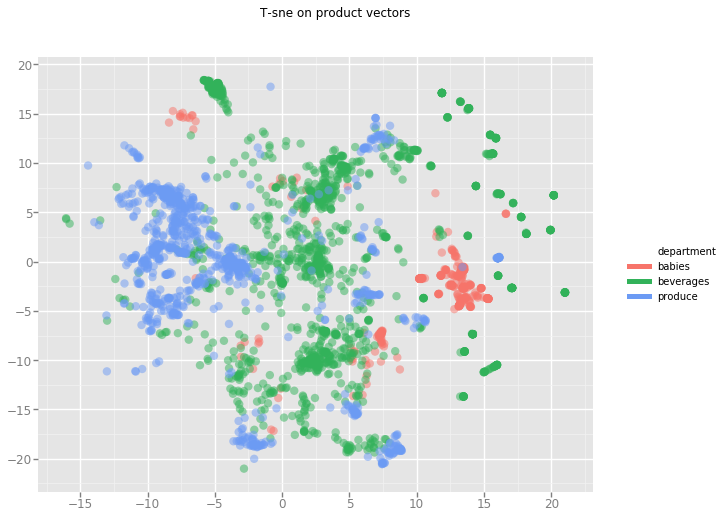

<ggplot: (2932409985442)>

In [134]:
tsne_plot = ggplot(tsne_plot_df, aes(x = "x_tsne", y = "y_tsne", color = "department") ) \
        + geom_point(size = 70, alpha = 0.5) \
        + ggtitle("T-sne on product vectors") \
        + xlab(" ") + ylab(" ")
tsne_plot

---